In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report
from statsmodels.stats.proportion import proportions_ztest

In [ ]:
df = pd.read_csv('Bank Customer Churn Prediction.csv')

In [ ]:
df = df[df['country'] == 'Germany']

# Feature 조정

## 이상치 처리 (isolation forest + Z-score)

In [ ]:
df['gender'] = df['gender'].apply(lambda x: 1 if x == 'Male' else 0)
df.drop(columns = ['customer_id', 'country'], inplace = True)
df.shape

(2509, 10)

In [ ]:
from sklearn.ensemble import IsolationForest
# ML 방식을 사용하여 이상치 열 생성
model = IsolationForest(contamination=0.1)  # 이상치 비율을 나타내는 매개변수
df['outlier'] = model.fit_predict(df)

# 통계적 방식을 사용하여 Z-score 열 생성
df['z'] = (df['credit_score'] - df['credit_score'].mean()) / df['credit_score'].std()

# 이상치 조건을 사용하여 이상치 여부 결정
df['is_outlier'] = (df['outlier'] == -1) & (abs(df['z']) > 3)

# 결과를 기준으로 df를 업데이트
df = df[df['is_outlier'] != True]
df.drop(columns = ['outlier', 'z', 'is_outlier'], inplace = True)

# outlier 제거 완료
df

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
<ipython-input-8-f9f105a5ba7a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns = ['outlier', 'z', 'is_outlier'], inplace = True)


,credit_score,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
7,376,0,29,4,115046.74,4,1,0,119346.88,1
15,616,1,45,3,143129.41,2,0,1,64327.26,0
16,653,1,58,1,132602.88,1,1,0,5097.67,1
26,756,1,36,2,136815.64,1,1,1,170041.95,0
28,574,0,43,3,141349.43,1,1,1,100187.43,0
...,...,...,...,...,...,...,...,...,...,...
9982,655,0,46,7,137145.12,1,1,0,115146.40,1
9984,602,1,35,7,90602.42,2,1,1,51695.41,0
9986,673,1,47,1,183579.54,2,0,1,34047.54,0
9990,714,1,33,3,35016.60,1,1,0,53667.08,0


## 데이터 그룹 생성 및 데이터 전처리

In [ ]:
def make_group(df, col, bins, labels) :
  return pd.cut(df[col], bins=bins, labels=labels)

In [ ]:
#age_group
# 결혼 및 아이의 독립을 기준으로 나누기
df['age_group'] = make_group(df, 'age', [18, 32, 56, 84], ['before marriage', 'after marriage', 'senior'])


# 베이비붐 세대: 46년생 ~ 64년생
# X세대: 65년생 ~ 80년생
# 밀레니얼 세대 (Y세대): 81년생 ~ 95년생
# Z세대: 96년생 ~ 12년생
# df['age_group'] = make_group(df, 'age', [18, 27, 42, 58, 84], ['Z', 'millennial', 'X', 'baby boom'])
#---------------------------------------------------------------------------------------------------------------


# salary_group : 통계값으로 나누기
df['salary_group'] = make_group(df, 'estimated_salary', [11.58, 51113.14, 102184.66, 151167.94, 199992.48], ['75', '50', '25', '0'])


#---------------------------------------------------------------------------------------------------------------

# balance의 경우 scaling 하여 사용합시다

# df['balance_group'] = make_group(df, 'balance', [27288.43, 102773.2, 119714.25, 137648.41, 214346.96], ['75', '50', '25', '0'])
# df.drop(columns = 'balance', inplace = True)

#---------------------------------------------------------------------------------------------------------------
# #credit score + credit_card 그룹
# # FICO 표준 평가 방법 [350, 579, 669, 739, 799, 850]을 modify해서 사용
df['credit_group'] = make_group(df, 'credit_score', [350, 579, 669, 739, 850], ['D', 'C', 'B', 'A'])
df['credit_group'] = df['credit_group'].astype(str)
df['combined_group'] = df['credit_group'] + df['credit_card'].astype(str)

df.shape

(2507, 14)

In [ ]:
df.drop(columns = 'age', inplace = True)
df.drop(columns = 'estimated_salary', inplace = True)
df.drop(columns = ['credit_score', 'credit_card', 'credit_group'], inplace = True)

In [ ]:
df.head()

,gender,tenure,balance,products_number,active_member,churn,age_group,salary_group,combined_group
7,0,4,115046.74,4,0,1,before marriage,25,D1
15,1,3,143129.41,2,1,0,after marriage,50,C0
16,1,1,132602.88,1,0,1,senior,75,C1
26,1,2,136815.64,1,1,0,after marriage,0,A1
28,0,3,141349.43,1,1,0,after marriage,50,D1


In [ ]:
# 스케일링할 변수 선택
columns_to_scale = ['balance','tenure']
# one-hot encoding할 변수 선택
columns_to_encode = ['products_number', 'age_group', 'salary_group', 'combined_group']

# StandardScaler 객체 생성
scaler = StandardScaler()

# 선택한 변수들에 대해 스케일링을 수행
df_scaled = df.copy()  # 데이터프레임 복사
df_scaled[columns_to_scale] = scaler.fit_transform(df_scaled[columns_to_scale])

# one-hot encoding 수행
df_encoded = pd.get_dummies(df_scaled, columns=columns_to_encode)

# one-hot encoding 결과 확인
df_encoded

,gender,tenure,balance,active_member,churn,products_number_1,products_number_2,products_number_3,products_number_4,age_group_before marriage,...,salary_group_25,salary_group_0,combined_group_A0,combined_group_A1,combined_group_B0,combined_group_B1,combined_group_C0,combined_group_C1,combined_group_D0,combined_group_D1
7,0,-0.345050,-0.172883,0,1,0,0,0,1,1,...,1,0,0,0,0,0,0,0,0,1
15,1,-0.685886,0.866725,1,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
16,1,-1.367558,0.477038,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
26,1,-1.026722,0.632992,1,0,1,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
28,0,-0.685886,0.800831,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9982,0,0.677457,0.645189,0,1,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
9984,1,0.677457,-1.077801,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
9986,1,-1.367558,2.364172,1,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
9990,1,-0.685886,-3.135564,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


# 모델 빌딩

## Logistic Regression

In [ ]:
# features와 target 분리
X = df_encoded.drop(columns = 'churn')
y = df_encoded['churn']  # churn을 target으로 사용

# train-test split (테스트 데이터는 계층적 샘플링을 사용하지 않습니다)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train-validation split (검증용 데이터는 계층적 샘플링을 사용합니다)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)  # 0.25 x 0.8 = 0.2

# 각 데이터셋의 크기 확인
print("Train set size:", X_train.shape)
print("Validation set size:", X_val.shape)
print("Test set size:", X_test.shape)

Train set size: (1503, 23)
Validation set size: (502, 23)
Test set size: (502, 23)


### train-test split(X_train_val, X_test, y_train_val, y_test)

훈련 세트 정확도: 0.7605985037406484
테스트 세트 정확도: 0.7529880478087649
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       341
           1       0.63      0.56      0.59       161

    accuracy                           0.75       502
   macro avg       0.72      0.70      0.71       502
weighted avg       0.75      0.75      0.75       502

AUC: 0.8086373654396095


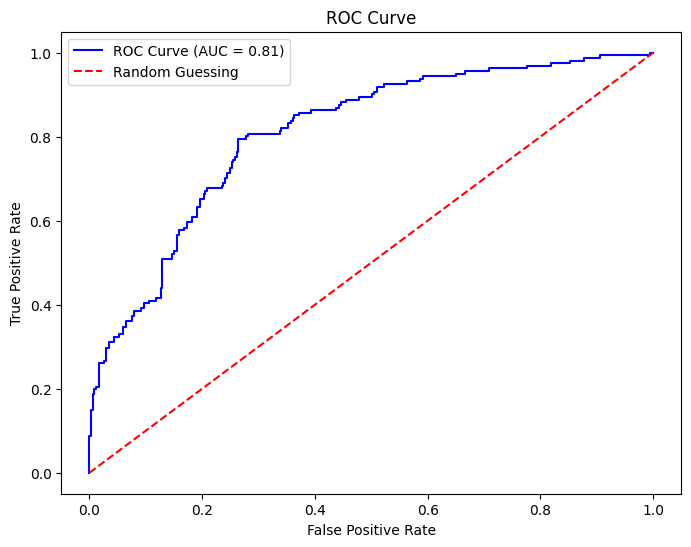

In [ ]:
# 로지스틱 회귀 모델 생성 및 학습
logistic_reg = LogisticRegression()
logistic_reg.fit(X_train_val, y_train_val)
# 모델 평가
train_accuracy = accuracy_score(y_train_val, logistic_reg.predict(X_train_val))
test_accuracy = accuracy_score(y_test, logistic_reg.predict(X_test))

print("훈련 세트 정확도:", train_accuracy)
print("테스트 세트 정확도:", test_accuracy)

from sklearn.metrics import classification_report

# 테스트 세트에 대한 예측 생성
y_pred = logistic_reg.predict(X_test)

# classification report 생성
report = classification_report(y_test, y_pred)

print(report)

from sklearn.metrics import roc_auc_score, roc_curve

# 예측 확률 계산
y_pred_proba = logistic_reg.predict_proba(X_test)[:, 1]

# AUC 계산
auc = roc_auc_score(y_test, y_pred_proba)
print("AUC:", auc)

# ROC 곡선 계산
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# ROC 곡선 그리기
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

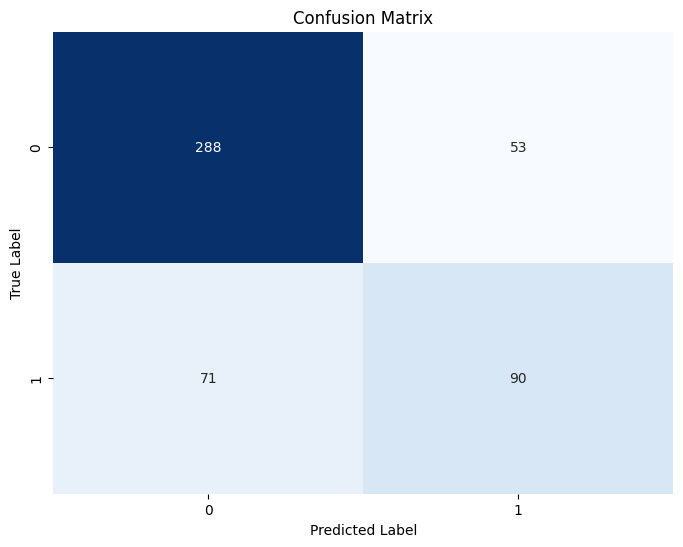

변수의 영향력:
                           Coefficient
gender                       -0.442197
tenure                       -0.022528
balance                       0.022889
active_member                -0.866781
products_number_1            -0.855968
products_number_2            -2.519964
products_number_3             1.517887
products_number_4             1.859428
age_group_before marriage    -0.749218
age_group_after marriage      0.685688
age_group_senior              1.214154
salary_group_75              -0.033152
salary_group_50              -0.192125
salary_group_25              -0.180167
salary_group_0               -0.226177
combined_group_A0             0.176304
combined_group_A1            -0.105415
combined_group_B0            -0.196102
combined_group_B1             0.043328
combined_group_C0            -0.086940
combined_group_C1             0.005448
combined_group_D0             0.130740
combined_group_D1             0.034020


<ipython-input-28-03ceb21f1841>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y=coefficients.index, data=coefficients, palette='viridis')


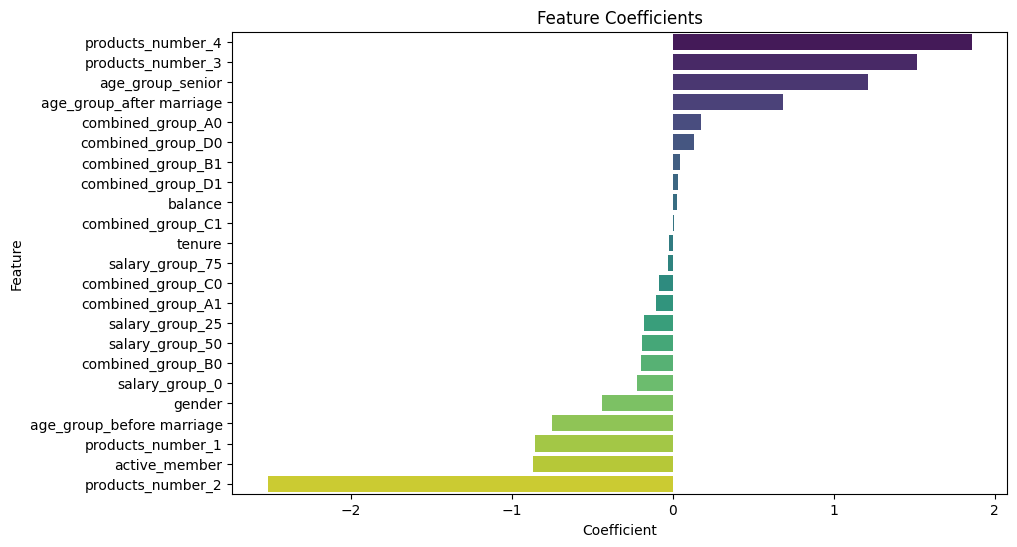

In [ ]:
# confusion matrix 계산
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 변수의 영향력 출력 (계수 확인)
coefficients = pd.DataFrame(logistic_reg.coef_.T, index=X_train.columns, columns=['Coefficient'])
print("변수의 영향력:")
print(coefficients)

# 변수의 영향력을 바 그래프로 표현
plt.figure(figsize=(10, 6))
coefficients.sort_values(by='Coefficient', ascending=False, inplace=True)  # 계수를 기준으로 내림차순 정렬
sns.barplot(x='Coefficient', y=coefficients.index, data=coefficients, palette='viridis')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Feature Coefficients')
plt.show()

### train-validation split(X_train, X_val, y_train, y_val)

훈련 세트 정확도: 0.7697937458416501
테스트 세트 정확도: 0.7330677290836654
              precision    recall  f1-score   support

           0       0.78      0.84      0.81       339
           1       0.60      0.52      0.56       163

    accuracy                           0.73       502
   macro avg       0.69      0.68      0.68       502
weighted avg       0.72      0.73      0.73       502

AUC: 0.7812403858334691


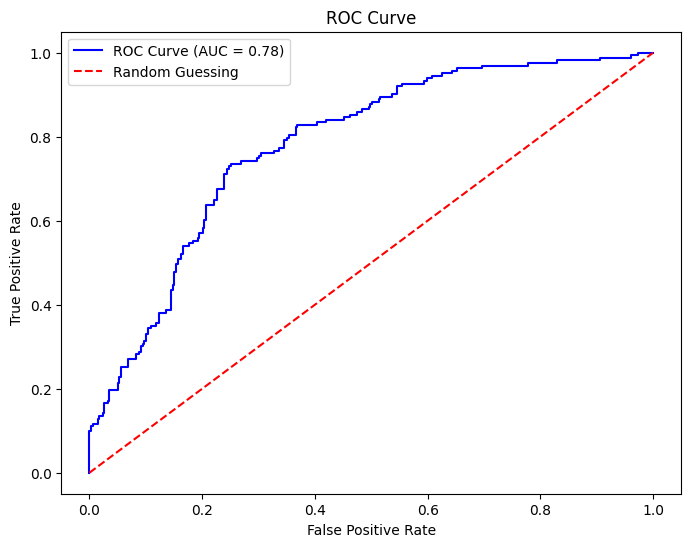

In [ ]:
# 로지스틱 회귀 모델 생성 및 학습
logistic_reg = LogisticRegression()
logistic_reg.fit(X_train, y_train)
# 모델 평가
train_accuracy = accuracy_score(y_train, logistic_reg.predict(X_train))
test_accuracy = accuracy_score(y_val, logistic_reg.predict(X_val))

print("훈련 세트 정확도:", train_accuracy)
print("테스트 세트 정확도:", test_accuracy)

from sklearn.metrics import classification_report

# 테스트 세트에 대한 예측 생성
y_pred = logistic_reg.predict(X_val)

# classification report 생성
report = classification_report(y_val, y_pred)

print(report)

from sklearn.metrics import roc_auc_score, roc_curve

# 예측 확률 계산
y_pred_proba = logistic_reg.predict_proba(X_val)[:, 1]

# AUC 계산
auc = roc_auc_score(y_val, y_pred_proba)
print("AUC:", auc)

# ROC 곡선 계산
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

# ROC 곡선 그리기
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

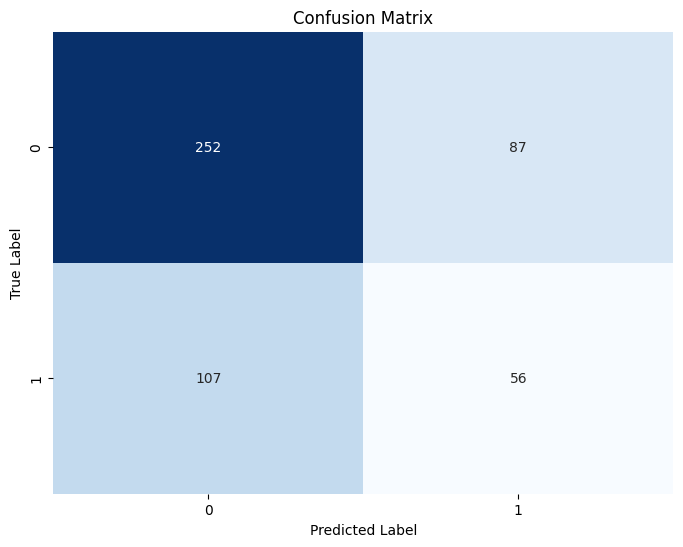

변수의 영향력:
                           Coefficient
gender                       -0.442197
tenure                       -0.022528
balance                       0.022889
active_member                -0.866781
products_number_1            -0.855968
products_number_2            -2.519964
products_number_3             1.517887
products_number_4             1.859428
age_group_before marriage    -0.749218
age_group_after marriage      0.685688
age_group_senior              1.214154
salary_group_75              -0.033152
salary_group_50              -0.192125
salary_group_25              -0.180167
salary_group_0               -0.226177
combined_group_A0             0.176304
combined_group_A1            -0.105415
combined_group_B0            -0.196102
combined_group_B1             0.043328
combined_group_C0            -0.086940
combined_group_C1             0.005448
combined_group_D0             0.130740
combined_group_D1             0.034020


<ipython-input-27-0ad2b1e9dc74>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y=coefficients.index, data=coefficients, palette='viridis')


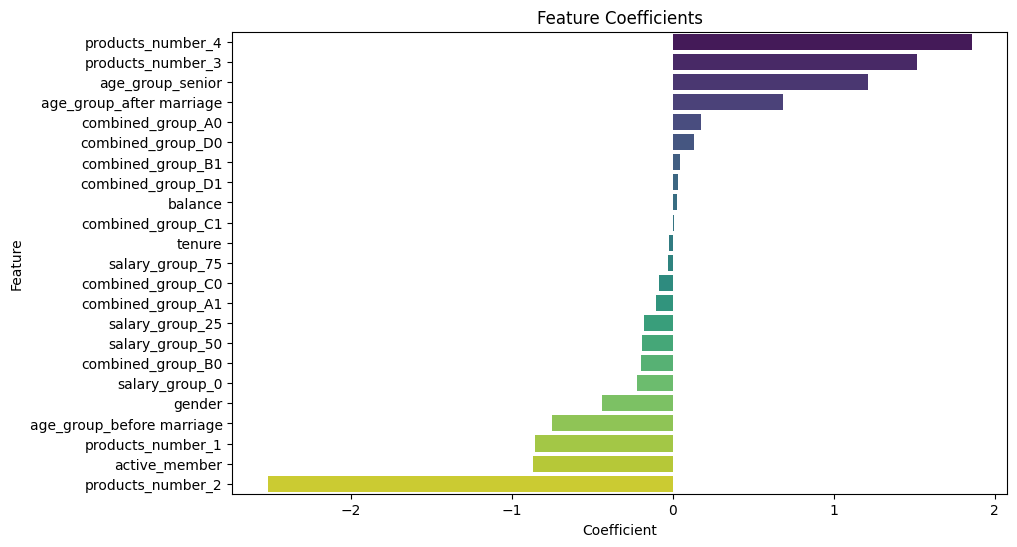

In [ ]:
# confusion matrix 계산
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_val, y_pred)

# confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 변수의 영향력 출력 (계수 확인)
coefficients = pd.DataFrame(logistic_reg.coef_.T, index=X_train.columns, columns=['Coefficient'])
print("변수의 영향력:")
print(coefficients)

# 변수의 영향력을 바 그래프로 표현
plt.figure(figsize=(10, 6))
coefficients.sort_values(by='Coefficient', ascending=False, inplace=True)  # 계수를 기준으로 내림차순 정렬
sns.barplot(x='Coefficient', y=coefficients.index, data=coefficients, palette='viridis')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Feature Coefficients')
plt.show()

## Random Forest

### train-test split(X_train_val, X_test, y_train_val, y_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# 데이터를 피처와 타겟 변수로 분리
X =  df_encoded.drop('churn', axis=1)
y =  df_encoded['churn']

# train-test split (테스트 데이터는 계층적 샘플링을 사용하지 않습니다)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 랜덤 포레스트 모델 생성
model = RandomForestClassifier()

# 탐색할 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [100, 200, 300],  # 결정 트리의 개수
    'max_depth': [None, 10, 20, 30],   # 트리의 최대 깊이
    'min_samples_split': [2, 5, 10],   # 노드를 분할하기 위한 최소 샘플 수
    'min_samples_leaf': [1, 2, 4],     # 리프 노드에 필요한 최소 샘플 수
    'max_features': ['auto', 'sqrt', 'log2'],  # 각 트리에서 고려할 최대 피처 수
    'bootstrap': [True, False]         # 부트스트랩 샘플링 사용 여부
}

# GridSearchCV 객체 생성
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# 그리드 탐색을 통한 모델 피팅
grid_search.fit(X_train_val, y_train_val)

# 최적의 하이퍼파라미터 출력
print("최적의 하이퍼파라미터:", grid_search.best_params_)

# 최적의 모델 추출
best_model = grid_search.best_estimator_


# 테스트 세트 예측
y_pred = best_model.predict(X_test)

# 모델 평가
accuracy = accuracy_score(y_test, y_pred)
print("정확도:", accuracy)

# classification report 출력
print("Classification Report:")
print(classification_report(y_test, y_pred))

# confusion matrix 출력
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


Fitting 5 folds for each of 648 candidates, totalling 3240 fits
최적의 하이퍼파라미터: {'bootstrap': True, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
정확도: 0.7689243027888446
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.85      0.83       341
           1       0.65      0.60      0.62       161

    accuracy                           0.77       502
   macro avg       0.73      0.72      0.73       502
weighted avg       0.76      0.77      0.77       502

Confusion Matrix:
[[290  51]
 [ 65  96]]


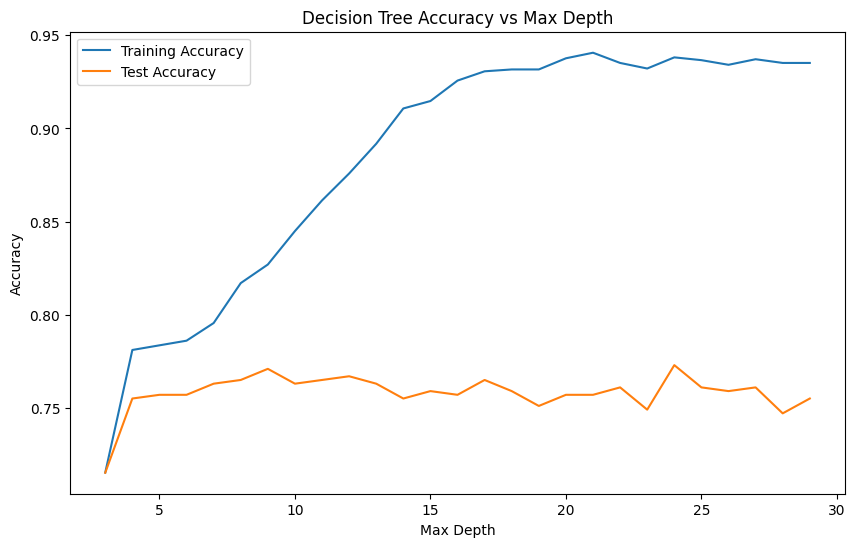

In [ ]:
# max depth에 따른 학습 결과 경향성 파악
max_depths = range(3, 30)

train_accuracies = []
test_accuracies = []

for depth in max_depths:
    model = RandomForestClassifier(n_estimators = 200, criterion='entropy',
                                   max_depth=depth,
                                   min_samples_split=5)
    model.fit(X_train_val, y_train_val)

    # 학습 데이터에 대한 정확도
    y_train_pred = model.predict(X_train_val)
    train_acc = accuracy_score(y_train_val, y_train_pred)
    train_accuracies.append(train_acc)

    # 평가 데이터에 대한 정확도
    y_test_pred = model.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)
    test_accuracies.append(test_acc)

# 결과 시각화
plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_accuracies, label='Training Accuracy')
plt.plot(max_depths, test_accuracies, label='Test Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Decision Tree Accuracy vs Max Depth')
plt.legend()
plt.show()

In [ ]:
# 최대 정확도를 달성하는 max_depth를 찾고 해당 depth로 최적 모델 학습
max_acc = max(test_accuracies)
best_depth = max_depths[test_accuracies.index(max_acc)]
print('최대 정확도의 depth :', best_depth)

dt = RandomForestClassifier(n_estimators = 200, criterion='entropy',
                                   max_depth=depth,
                                   min_samples_split=5)

최대 정확도의 depth : 24


In [ ]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# 랜덤 포레스트 모델 생성
model = RandomForestClassifier()

# 모델 학습
model.fit(X_train, y_train)

# 피처의 중요도 출력
feature_importances = model.feature_importances_
print("피처의 중요도:", feature_importances)

# 중요도를 데이터프레임으로 변환하여 피처 이름과 함께 출력
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
print(feature_importance_df)


피처의 중요도: [0.0355654  0.1613442  0.27111668 0.05365941 0.04236178 0.09215578
 0.0317616  0.01134279 0.03636871 0.02577809 0.01531358 0.0228224
 0.02325891 0.0233427  0.01934682 0.0139806  0.01769146 0.01325768
 0.01848529 0.01328059 0.02511187 0.01204984 0.02060383]
                      Feature  Importance
0                      gender    0.035565
1                      tenure    0.161344
2                     balance    0.271117
3               active_member    0.053659
4           products_number_1    0.042362
5           products_number_2    0.092156
6           products_number_3    0.031762
7           products_number_4    0.011343
8   age_group_before marriage    0.036369
9    age_group_after marriage    0.025778
10           age_group_senior    0.015314
11            salary_group_75    0.022822
12            salary_group_50    0.023259
13            salary_group_25    0.023343
14             salary_group_0    0.019347
15          combined_group_A0    0.013981
16          combined

### train-validation split(X_train, X_val, y_train, y_val)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# 데이터를 피처와 타겟 변수로 분리
X =  df_encoded.drop('churn', axis=1)
y =  df_encoded['churn']

# train-validation split (검증용 데이터는 계층적 샘플링을 사용합니다)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)  # 0.25 x 0.8 = 0.2

# 랜덤 포레스트 모델 생성
rf_model = RandomForestClassifier()

# 탐색할 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [100, 200, 300],  # 결정 트리의 개수
    'max_depth': [None, 10, 20, 30],   # 트리의 최대 깊이
    'min_samples_split': [2, 5, 10],   # 노드를 분할하기 위한 최소 샘플 수
    'min_samples_leaf': [1, 2, 4],     # 리프 노드에 필요한 최소 샘플 수
    'max_features': ['auto', 'sqrt', 'log2'],  # 각 트리에서 고려할 최대 피처 수
    'bootstrap': [True, False]         # 부트스트랩 샘플링 사용 여부
}

# GridSearchCV 객체 생성
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# 그리드 탐색을 통한 모델 피팅
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print("최적의 하이퍼파라미터:", grid_search.best_params_)

# 최적의 모델 추출
best_rf_model = grid_search.best_estimator_


# 테스트 세트 예측
y_pred = best_rf_model.predict(X_val)

# 모델 평가
accuracy = accuracy_score(y_val, y_pred)
print("정확도:", accuracy)

# classification report 출력
print("Classification Report:")
print(classification_report(y_val, y_pred))

# confusion matrix 출력
conf_matrix = confusion_matrix(y_val, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


KeyboardInterrupt: 

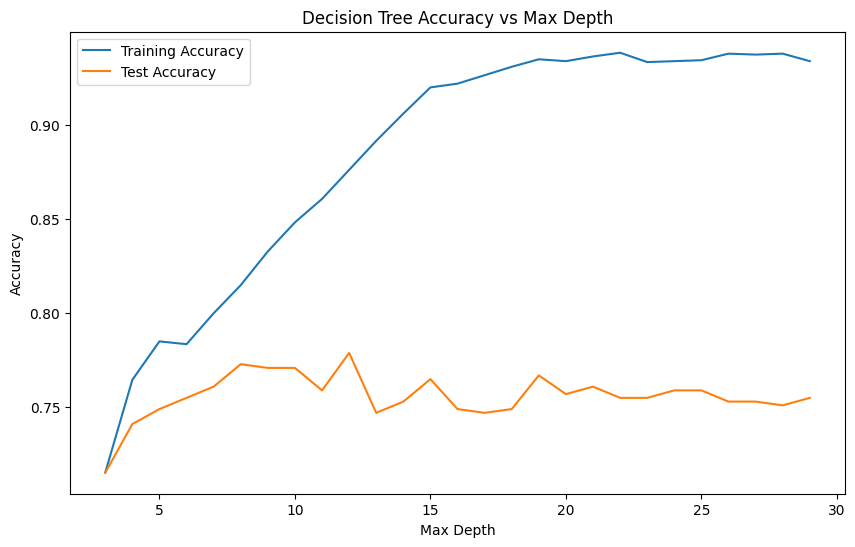

In [ ]:
# max depth에 따른 학습 결과 경향성 파악
max_depths = range(3, 30)

train_accuracies = []
test_accuracies = []

for depth in max_depths:
    model = RandomForestClassifier(n_estimators = 200, criterion='entropy',
                                   max_depth=depth,
                                   min_samples_split=5)
    model.fit(X_train_val, y_train_val)

    # 학습 데이터에 대한 정확도
    y_train_pred = model.predict(X_train_val)
    train_acc = accuracy_score(y_train_val, y_train_pred)
    train_accuracies.append(train_acc)

    # 평가 데이터에 대한 정확도
    y_test_pred = model.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)
    test_accuracies.append(test_acc)

# 결과 시각화
plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_accuracies, label='Training Accuracy')
plt.plot(max_depths, test_accuracies, label='Test Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Decision Tree Accuracy vs Max Depth')
plt.legend()
plt.show()

In [ ]:
# 최대 정확도를 달성하는 max_depth를 찾고 해당 depth로 최적 모델 학습
max_acc = max(test_accuracies)
best_depth = max_depths[test_accuracies.index(max_acc)]
print('최대 정확도의 depth :', best_depth)

dt = RandomForestClassifier(n_estimators = 200, criterion='entropy',
                                   max_depth=depth,
                                   min_samples_split=5)

최대 정확도의 depth : 12


In [ ]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# 랜덤 포레스트 모델 생성
model = RandomForestClassifier()

# 모델 학습
model.fit(X_train, y_train)

# 피처의 중요도 출력
feature_importances = model.feature_importances_
print("피처의 중요도:", feature_importances)

# 중요도를 데이터프레임으로 변환하여 피처 이름과 함께 출력
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
print(feature_importance_df)

피처의 중요도: [0.03842764 0.16031788 0.26966533 0.05430803 0.03894189 0.09519144
 0.03369094 0.01281454 0.03516693 0.027482   0.01610455 0.02269175
 0.02480697 0.02312922 0.01967562 0.01265859 0.01801243 0.01327334
 0.01690062 0.01244893 0.02322456 0.01097507 0.02009172]
                      Feature  Importance
0                      gender    0.038428
1                      tenure    0.160318
2                     balance    0.269665
3               active_member    0.054308
4           products_number_1    0.038942
5           products_number_2    0.095191
6           products_number_3    0.033691
7           products_number_4    0.012815
8   age_group_before marriage    0.035167
9    age_group_after marriage    0.027482
10           age_group_senior    0.016105
11            salary_group_75    0.022692
12            salary_group_50    0.024807
13            salary_group_25    0.023129
14             salary_group_0    0.019676
15          combined_group_A0    0.012659
16          combine

## Gradient Boosting

### train-test split(X_train_val, X_test, y_train_val, y_test)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# 데이터를 피처와 타겟 변수로 분리
X =  df_encoded.drop('churn', axis=1)
y =  df_encoded['churn']

# train-test split (테스트 데이터는 계층적 샘플링을 사용하지 않습니다)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 그래디언트 부스팅 모델 생성
gb_model = GradientBoostingClassifier()

# 탐색할 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [100, 200, 300],  # 트리의 개수
    'learning_rate': [0.01, 0.1, 0.5], # 학습률
    'max_depth': [3, 5, 7],            # 트리의 최대 깊이
    'min_samples_split': [2, 5, 10],   # 노드를 분할하기 위한 최소 샘플 수
    'min_samples_leaf': [1, 2, 4],     # 리프 노드에 필요한 최소 샘플 수
    'max_features': ['auto', 'sqrt', 'log2'],  # 각 트리에서 고려할 최대 피처 수
}

# GridSearchCV 객체 생성
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# 그리드 탐색을 통한 모델 피팅
grid_search.fit(X_train_val, y_train_val)

# 최적의 하이퍼파라미터 출력
print("최적의 하이퍼파라미터:", grid_search.best_params_)

# 최적의 모델 추출
best_gb_model = grid_search.best_estimator_

# 최적의 모델로 예측 수행
y_pred = best_gb_model.predict(X_test)

# 모델 평가
accuracy = accuracy_score(y_test, y_pred)
print("정확도:", accuracy)

# classification report 출력
print("Classification Report:")
print(classification_report(y_test, y_pred))

# confusion matrix 출력
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)



Fitting 5 folds for each of 729 candidates, totalling 3645 fits
최적의 하이퍼파라미터: {'learning_rate': 0.1, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
정확도: 0.7768924302788844
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       341
           1       0.66      0.63      0.64       161

    accuracy                           0.78       502
   macro avg       0.74      0.74      0.74       502
weighted avg       0.77      0.78      0.78       502

Confusion Matrix:
[[289  52]
 [ 60 101]]


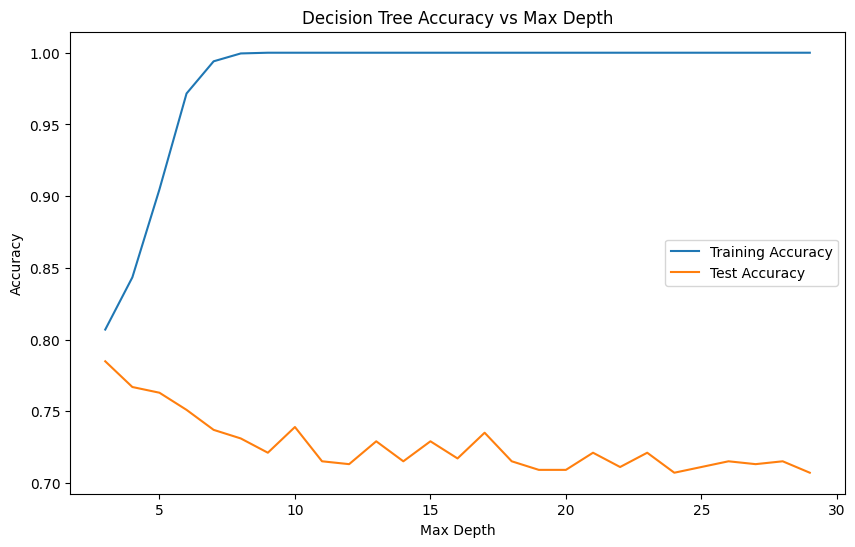

In [ ]:
# max depth에 따른 학습 결과 경향성 파악
max_depths = range(3, 30)

train_accuracies = []
test_accuracies = []

for depth in max_depths:
    model = GradientBoostingClassifier(n_estimators = 100,learning_rate=0.1,
                                   max_depth=depth,
                                   min_samples_split=5)
    model.fit(X_train_val, y_train_val)

    # 학습 데이터에 대한 정확도
    y_train_pred = model.predict(X_train_val)
    train_acc = accuracy_score(y_train_val, y_train_pred)
    train_accuracies.append(train_acc)

    # 평가 데이터에 대한 정확도
    y_test_pred = model.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)
    test_accuracies.append(test_acc)

# 결과 시각화
plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_accuracies, label='Training Accuracy')
plt.plot(max_depths, test_accuracies, label='Test Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Decision Tree Accuracy vs Max Depth')
plt.legend()
plt.show()

In [ ]:
# 최대 정확도를 달성하는 max_depth를 찾고 해당 depth로 최적 모델 학습
max_acc = max(test_accuracies)
best_depth = max_depths[test_accuracies.index(max_acc)]
print('최대 정확도의 depth :', best_depth)

dt = GradientBoostingClassifier(n_estimators = 100,learning_rate=0.01,
                                   max_depth=depth,
                                min_samples_split=5)

최대 정확도의 depth : 3


### train-validation split(X_train, X_val, y_train, y_val)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# 데이터를 피처와 타겟 변수로 분리
X =  df_encoded.drop('churn', axis=1)
y =  df_encoded['churn']

# train-validation split (검증용 데이터는 계층적 샘플링을 사용합니다)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)  # 0.25 x 0.8 = 0.2

# 그래디언트 부스팅 모델 생성
model = GradientBoostingClassifier(n_estimators = 100,learning_rate=0.1,
                                   max_depth=3,
                                   min_samples_split=5)

# 모델 학습
model.fit(X_train, y_train)

# 테스트 세트 예측
y_pred = model.predict(X_val)

# 모델 평가
accuracy = accuracy_score(y_val, y_pred)
print("정확도:", accuracy)

# classification report 출력
print("Classification Report:")
print(classification_report(y_val, y_pred))

# confusion matrix 출력
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

정확도: 0.7729083665338645
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.90      0.84       339
           1       0.71      0.52      0.60       163

    accuracy                           0.77       502
   macro avg       0.75      0.71      0.72       502
weighted avg       0.77      0.77      0.76       502

Confusion Matrix:
[[251  90]
 [132  29]]


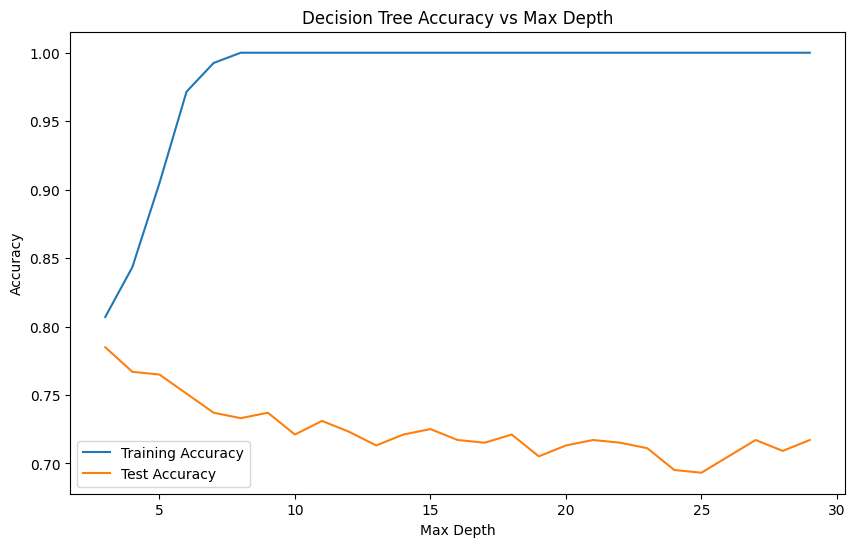

In [ ]:
# max depth에 따른 학습 결과 경향성 파악
max_depths = range(3, 30)

train_accuracies = []
test_accuracies = []

for depth in max_depths:
    model = GradientBoostingClassifier(n_estimators = 100,learning_rate=0.1,
                                   max_depth=depth,
                                   min_samples_split=5)
    model.fit(X_train_val, y_train_val)

    # 학습 데이터에 대한 정확도
    y_train_pred = model.predict(X_train_val)
    train_acc = accuracy_score(y_train_val, y_train_pred)
    train_accuracies.append(train_acc)

    # 평가 데이터에 대한 정확도
    y_test_pred = model.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)
    test_accuracies.append(test_acc)

# 결과 시각화
plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_accuracies, label='Training Accuracy')
plt.plot(max_depths, test_accuracies, label='Test Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Decision Tree Accuracy vs Max Depth')
plt.legend()
plt.show()

In [ ]:
# 최대 정확도를 달성하는 max_depth를 찾고 해당 depth로 최적 모델 학습
max_acc = max(test_accuracies)
best_depth = max_depths[test_accuracies.index(max_acc)]
print('최대 정확도의 depth :', best_depth)

dt = GradientBoostingClassifier(n_estimators = 100,learning_rate=0.01,
                                   max_depth=depth,
                                min_samples_split=5)

최대 정확도의 depth : 3


다음으로 최적의 파라미터를 찾아보자